**Solution By:** Vipin Choudhary

**Project:** Bank Churn Prediction
Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

**Datasets Information:**
The case study is from an open-source dataset from Kaggle. The dataset contains 10,000 sample points with 14 distinct features such as CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance, etc.
Link to the Kaggle project site:https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

**Solution Used:** DNN


Import the Libraires

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers

Mounting Gdrive

In [28]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [29]:
project_path = '/gdrive/My Drive/Colab Notebooks/'

In [30]:
dataset_file = project_path + 'bank.csv'

Reading Datafile

In [31]:
data = pd.read_csv(dataset_file)

***Exploratory Data Analysis***


In [32]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Since first three features RowNumber, CustomerId & Surname either uniquely identifies a row or identifies a customer, it's of no importance to us. Dropping first three features

In [33]:
data = data.drop("RowNumber", axis = 1)
data = data.drop("CustomerId", axis = 1)
data = data.drop("Surname", axis = 1)




In [34]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


We have to categorical features. We will be encoding them in the later steps.

1.   Geography
2.   Gender



No Null values are there in the dataframe



In [36]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


Looking at the mean and median(50%) for most of the fields, we can say that:


*   There are no major outliers for most of the fields as mean and median are  very close
*   Median is higher than mean for Balance & Estimated Salary. Also, the u nit for these two fields is currency. This will be resloved through scaling.



***Univariate and Bi variate Analysis***

In [37]:

def plot_corr(df, size=15):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for (i, j), z in np.ndenumerate(corr):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

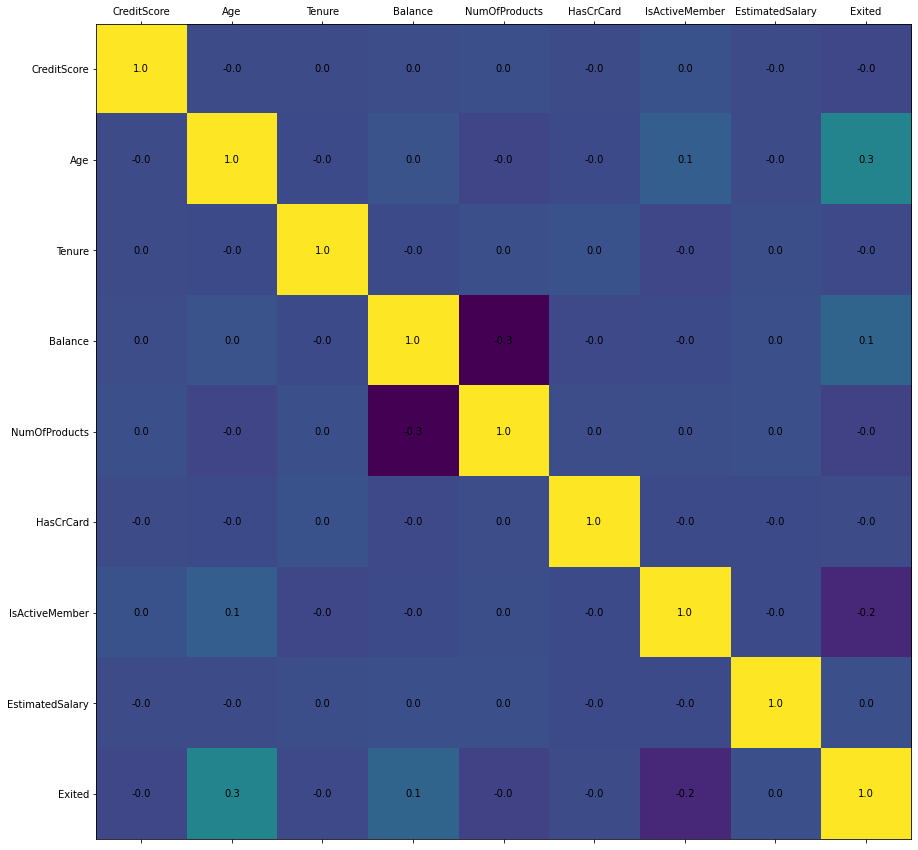

In [38]:
plot_corr(data)

No Major corelation we can see in any of the fields

In [39]:
data['Geography'].value_counts(True)

France     0.5014
Germany    0.2509
Spain      0.2477
Name: Geography, dtype: float64

In [40]:
data['Gender'].value_counts(True)

Male      0.5457
Female    0.4543
Name: Gender, dtype: float64

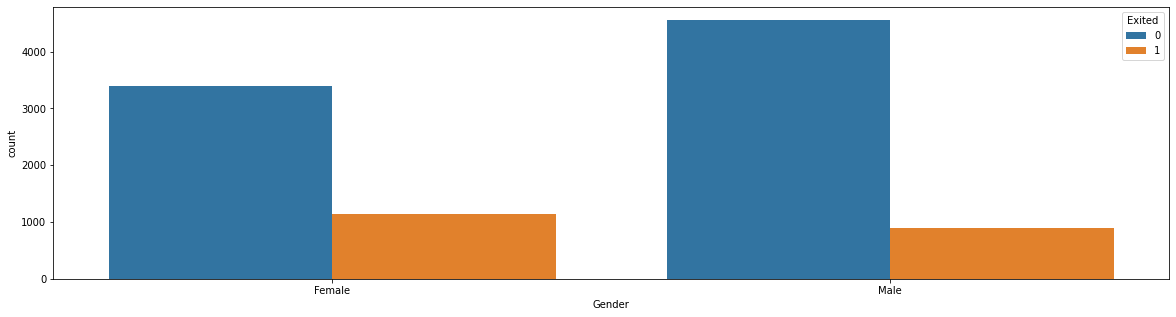

In [41]:
import seaborn as sns
plt.figure(figsize=(20,5))
sns.countplot(x=data['Gender'],hue=data['Exited'])

% of exited customers is higher for females as compared to males

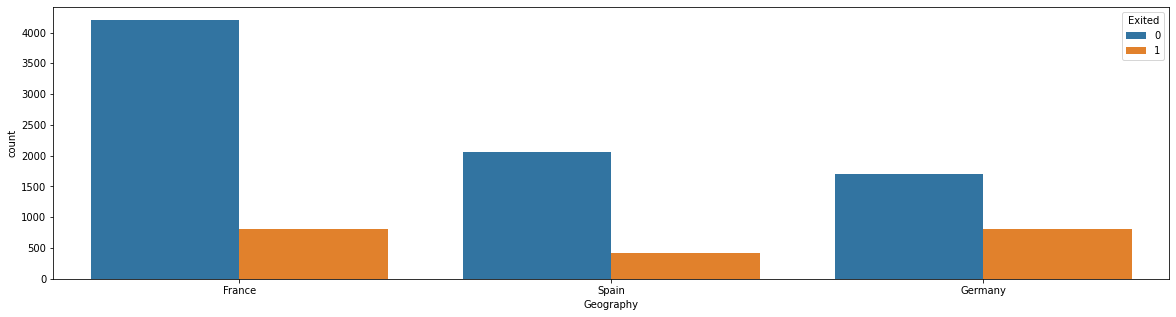

In [42]:
plt.figure(figsize=(20,5))
sns.countplot(x=data['Geography'],hue=data['Exited'])

%age of exited customers is higher for germany. 

Maximum customers are from France in the dataframe

In [43]:
# Contingency table

def get_contingency_table(df,Target,var):
    ct_res = pd.crosstab(df[var],df[Target],margins=True)
    ct_res["Exited (%)"]=round(ct_res[1]/ct_res['All']*100,2)
    return ct_res.drop(columns=["All"])


In [44]:
get_contingency_table(data,'Exited','Gender')

Exited,0,1,Exited (%)
Gender,,,
Female,3404,1139,25.07
Male,4559,898,16.46
All,7963,2037,20.37


In [45]:
get_contingency_table(data,'Exited','Geography')

Exited,0,1,Exited (%)
Geography,,,
France,4204,810,16.15
Germany,1695,814,32.44
Spain,2064,413,16.67
All,7963,2037,20.37


In [46]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Spliting dependent and independent features

In [47]:
X = data.iloc[:, 0:9].values
y = data.iloc[:, 10].values
print(X[:10,:], '\n')
print(y[:10])

[[619 'France' 'Female' 42 2 0.0 1 1 1]
 [608 'Spain' 'Female' 41 1 83807.86 1 0 1]
 [502 'France' 'Female' 42 8 159660.8 3 1 0]
 [699 'France' 'Female' 39 1 0.0 2 0 0]
 [850 'Spain' 'Female' 43 2 125510.82 1 1 1]
 [645 'Spain' 'Male' 44 8 113755.78 2 1 0]
 [822 'France' 'Male' 50 7 0.0 2 1 1]
 [376 'Germany' 'Female' 29 4 115046.74 4 1 0]
 [501 'France' 'Male' 44 4 142051.07 2 0 1]
 [684 'France' 'Male' 27 2 134603.88 1 1 1]] 

[1 0 1 0 0 1 0 1 0 0]


Encoding Gender and Geography by using sklearn’s LabelEncoder and OneHotEncoder

In [48]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.compose import ColumnTransformer

label_encoder_x_1 = LabelEncoder()
X[: , 1] = label_encoder_x_1.fit_transform(X[:,1])


label_encoder_x_2 = LabelEncoder()
X[: , 2] = label_encoder_x_1.fit_transform(X[:,2])


 

In [49]:
 transformer = ColumnTransformer(
     transformers=[
         ("OneHot",       
          OneHotEncoder(), 
          [1,2]              
          )
    ],
     remainder='passthrough'
 )
 # Transforming into float64
 X = transformer.fit_transform(X.tolist())
 X = X.astype('float64')
 X = X[:, 1:]



Splitting the dataset into the Training set and Test set and normalizing the train and test data

In [50]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#Rather than checking and improving the hyper parameters individually. Using Grid search CV to get the best parameters and implement the model

In [51]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

In [52]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
def build_classifier(optimizer):
     classifier = Sequential()
     classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 11))
     classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
     classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
     classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
     return classifier
classifier = KerasClassifier(build_fn = build_classifier)
parameters = {'batch_size': [10,20],'epochs': [20,100], 'optimizer': ['adam', 'rmsprop']}
grid_search = GridSearchCV(estimator = classifier,
param_grid = parameters, scoring = 'accuracy',cv = 10)
grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

Epoch 1/20
720/720 [==============================] - 1s 2ms/step - loss: 0.5982 - accuracy: 0.7831
Epoch 2/20
720/720 [==============================] - 1s 2ms/step - loss: 0.4492 - accuracy: 0.7920
Epoch 3/20
720/720 [==============================] - 1s 2ms/step - loss: 0.4215 - accuracy: 0.7982
Epoch 4/20
720/720 [==============================] - 1s 2ms/step - loss: 0.4220 - accuracy: 0.8160
Epoch 5/20
720/720 [==============================] - 1s 2ms/step - loss: 0.4266 - accuracy: 0.8179
Epoch 6/20
720/720 [==============================] - 1s 2ms/step - loss: 0.4228 - accuracy: 0.8221
Epoch 7/20
720/720 [==============================] - 1s 2ms/step - loss: 0.4192 - accuracy: 0.8248
Epoch 8/20
720/720 [==============================] - 1s 2ms/step - loss: 0.4090 - accuracy: 0.8356
Epoch 9/20
720/720 [==============================] - 1s 2ms/step - loss: 0.4013 - accuracy: 0.8370
Epoch 10/20
720/720 [==============================] - 1s 2ms/step - loss: 0.4102 - accuracy: 0.8318

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Streaming output truncated to the last 5000 lines.
Epoch 1/20
360/360 [==============================] - 1s 2ms/step - loss: 0.6096 - accuracy: 0.7934
Epoch 2/20
360/360 [==============================] - 1s 2ms/step - loss: 0.4409 - accuracy: 0.7940
Epoch 3/20
360/360 [==============================] - 1s 2ms/step - loss: 0.4362 - accuracy: 0.7937
Epoch 4/20
360/360 [==============================] - 1s 2ms/step - loss: 0.4305 - accuracy: 0.7962
Epoch 5/20
360/360 [==============================] - 1s 2ms/step - loss: 0.4285 - accuracy: 0.7929
Epoch 6/20
360/360 [==============================] - 1s 2ms/step - loss: 0.4303 - accuracy: 0.7965
Epoch 7/20
360/360 [==============================] - 1s 2ms/step - loss: 0.4157 - accuracy: 0.8145
Epoch 8/20
360/360 [==============================] - 1s 2ms/step - loss: 0.4207 - accuracy: 0.8186
Epoch 9/20
360/360 [==============================] - 1s 2ms/step - loss: 0.4269 - accuracy: 0.8217
Epoch 10/20
360/360 [============================

In [53]:
print(best_parameters)
print(best_accuracy)

{'batch_size': 20, 'epochs': 100, 'optimizer': 'rmsprop'}
0.8386250000000001


Defining as a sequence of layers and initializing the DNN as per the best parameters

In [54]:
classifier = Sequential()

In [55]:
#Input Layer
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 11 ))

In [56]:
# Hidden Layer
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))

In [57]:
# Output Layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

In [58]:
classifier.compile(optimizer = 'adam',loss= "binary_crossentropy",metrics=["accuracy"])

In order to find the best wieghts, using ADAM optimizer. Also using binary_crossentropy cost function for back propogation

In [59]:
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100  )

Epoch 1/100
800/800 [==============================] - 2s 2ms/step - loss: 0.5861 - accuracy: 0.7856
Epoch 2/100
800/800 [==============================] - 1s 2ms/step - loss: 0.4335 - accuracy: 0.7943
Epoch 3/100
800/800 [==============================] - 1s 2ms/step - loss: 0.4230 - accuracy: 0.7967
Epoch 4/100
800/800 [==============================] - 1s 2ms/step - loss: 0.4207 - accuracy: 0.7937
Epoch 5/100
800/800 [==============================] - 1s 2ms/step - loss: 0.4200 - accuracy: 0.8012
Epoch 6/100
800/800 [==============================] - 1s 2ms/step - loss: 0.4130 - accuracy: 0.8256
Epoch 7/100
800/800 [==============================] - 1s 2ms/step - loss: 0.4085 - accuracy: 0.8346
Epoch 8/100
800/800 [==============================] - 1s 2ms/step - loss: 0.4081 - accuracy: 0.8328
Epoch 9/100
800/800 [==============================] - 1s 2ms/step - loss: 0.4114 - accuracy: 0.8323
Epoch 10/100
800/800 [==============================] - 1s 2ms/step - loss: 0.4111 - accura

Predicting the test results and as per the given problem statement, applying the threshold of 50%

In [60]:
#Predicting the Test set results
y_pred = classifier.predict(X_test)
#Threshold of 50%
y_pred = (y_pred > 0.5)
y_pred

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

Printing Confusion matrix & Accuracy of 85%

In [61]:
#Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[1550,   45],
       [ 275,  130]])

In [62]:
import sklearn.metrics as metrics
cr=metrics.classification_report(y_test,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.85      0.97      0.91      1595
           1       0.74      0.32      0.45       405

    accuracy                           0.84      2000
   macro avg       0.80      0.65      0.68      2000
weighted avg       0.83      0.84      0.81      2000



##Accuracy of 85% achieved by implementing the above DNN